In [1]:
%mkdir -p prodata/test4

In [2]:
from scipy.stats import ttest_ind

from tqdm.auto import tqdm
import numpy as np

import pandas as pd

import json

from statsmodels.stats.multitest import multipletests

/home/paul/miniconda3/envs/skbio/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from scipy.stats import norm

def hodges_lehmann(vals, alpha=0.01):

    A, B = vals

    n = len(A)
    m = len(B)

    M = list(sorted([a - b for a in A for b in B]))

    # https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test#Normal_approximation_and_tie_correction
    # half of sample size +- z score for CI * pooled std of sample size
    # expected U H0, sd U H0
    ZN = norm.ppf(1 - alpha / 2)  # one of tails
    EUH0 = n * m / 2
    SUH0 = (n * m * (n + m + 1) / 12)**0.5

    L = EUH0 - ZN * SUH0
    U = EUH0 + ZN * SUH0

    # for python
    lower = int(round(L) - 1)
    upper = int(round(U) - 1)

    # for boundaries
    lower = max(lower, 0)
    upper = min(upper, len(M) - 1)

    lower = M[lower]
    upper = M[upper]

    return (lower, upper)

In [3]:
counts = pd.read_table('data/ibd/data_counts.tsv', index_col=0)
relab = pd.read_table('data/ibd/data_tss.tsv', index_col=0)
meta = pd.read_table('data/ibd/meta.tsv', index_col=0)

# classified, prevalence 50%
counts = counts[[c for c in list(counts) if 'unclass' not in c]]
c = counts.replace(0, np.nan).notna().mean()
usecols = c[c > 0.5].index
print(len(usecols), counts.shape[1])

counts = counts[usecols]
relab = relab[usecols]

# map column names to simpler one for R
map_columns = dict(zip(list(counts), [f"t{k}" for k in range(len(usecols))]))

for SIZE in tqdm([15, 25, 50, 100]):
    for SEED in range(50):
        DRAW = True

        np.random.seed(SEED)
        sub1 = counts[meta.Group == 'HR'].sample(n=SIZE)
        sub2 = counts[meta.Group != 'HR'].sample(n=SIZE)
        sub = pd.concat((sub1, sub2))

        sub.rename(columns=map_columns).to_csv(
            f'prodata/test4/ancomb_counts_{SIZE}_{SEED}.tsv', sep='\t')

        relab.loc[sub.index, sub.columns].to_csv(
            f'prodata/test4/hle_relab_{SIZE}_{SEED}.tsv', sep='\t')
        
        meta.loc[sub.index][['Group', 'Group']].to_csv(
            f'prodata/test4/ancomb_meta_{SIZE}_{SEED}.tsv', sep='\t')

343 2272


100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.69s/it]


In [6]:
res1 = pd.read_excel('prodata/ancomb_ibd_results_NA.xlsx', index_col=0)
res2 = pd.read_excel('prodata/ancomb_ibd_results_HOLM.xlsx', index_col=0)
res3 = pd.read_excel('prodata/ancomb_ibd_results_BH.xlsx', index_col=0)

res4 = pd.read_excel('prodata/hle_ibd_results005.xlsx', index_col=0)
res5 = pd.read_excel('prodata/hle_ibd_results001.xlsx', index_col=0)
res6 = pd.read_excel('prodata/hle_ibd_results0001.xlsx', index_col=0)

100%|███████████████████████████████████████████████████████████████████████████| 4/4 [01:49<00:00, 27.34s/it]


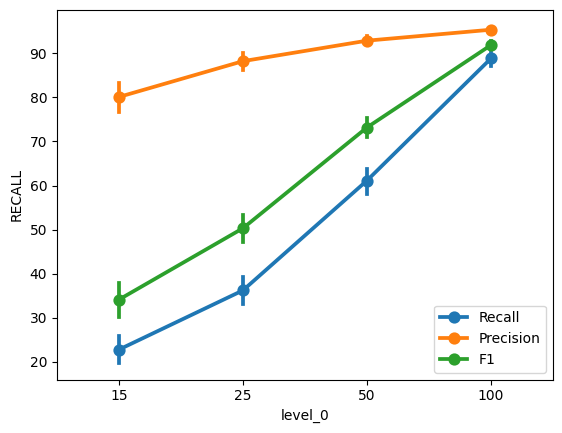

100%|███████████████████████████████████████████████████████████████████████████| 4/4 [01:48<00:00, 27.11s/it]


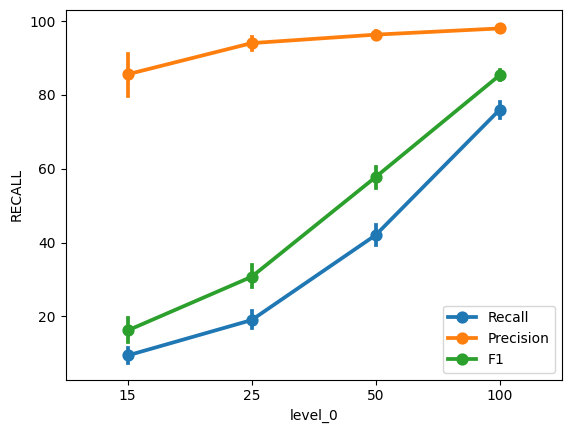

100%|███████████████████████████████████████████████████████████████████████████| 4/4 [01:43<00:00, 25.97s/it]


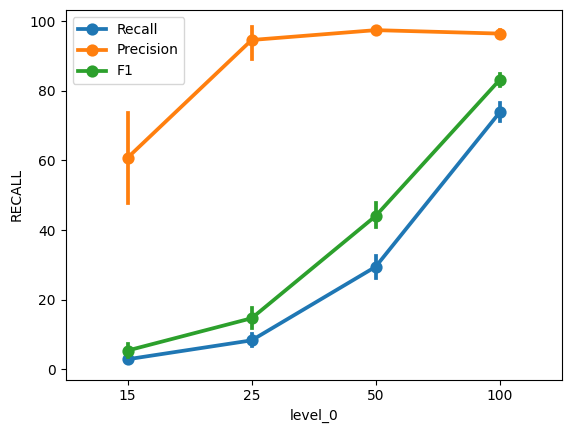

In [14]:
HLERES = {}

for ALPHA, FULLREF in zip([0.05, 0.01, 0.001], [res4, res5, res6]):

    RES = {}

    for SIZE in tqdm([15, 25, 50, 100]):
        for SEED in range(50):
            data = pd.read_table(f'prodata/test4/hle_relab_{SIZE}_{SEED}.tsv',
                                 index_col=0)

            meta = pd.read_table(
                f'prodata/test4/ancomb_meta_{SIZE}_{SEED}.tsv', index_col=0)

            MARKED = []
            for col in list(data):
                vals = [
                    data[meta.Group == 'HR'][col].values,
                    data[meta.Group == 'IBD'][col].values
                ]
                ci = CI = hodges_lehmann(vals, ALPHA)
                strict = np.sign(ci[0]) == np.sign(ci[1]) and (ci[0] != 0
                                                               and ci[1] != 0)

                if strict:
                    MARKED.append(col)

            FP = len([m for m in MARKED if m not in FULLREF.index])
            TP = len([m for m in MARKED if m in FULLREF.index])

            RECALL = (TP / len(FULLREF.index) * 100) if len(MARKED) > 0 else 0
            PRECISION = (TP / len(MARKED) * 100) if len(MARKED) > 0 else 0

            F1 = 0
            if PRECISION > 0 and RECALL > 0:
                F1 = 2 * ((PRECISION * RECALL) / (PRECISION + RECALL))

            RES[(SIZE, SEED)] = {
                'FP': FP,
                'TP': TP,
                'RECALL': RECALL,
                'PRECISION': PRECISION,
                'F1': F1,
                'markers': MARKED
            }

    RES = pd.DataFrame(RES).T.reset_index()
    HLERES[ALPHA] = RES
    RES.to_excel(f'prodata/hle_ibd_subsets_results_{ALPHA}.xlsx')

    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.pointplot(data=RES, x='level_0', y='RECALL', label='Recall')
    sns.pointplot(data=RES, x='level_0', y='PRECISION', label='Precision')
    sns.pointplot(data=RES, x='level_0', y='F1', label='F1')
    
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.05it/s]


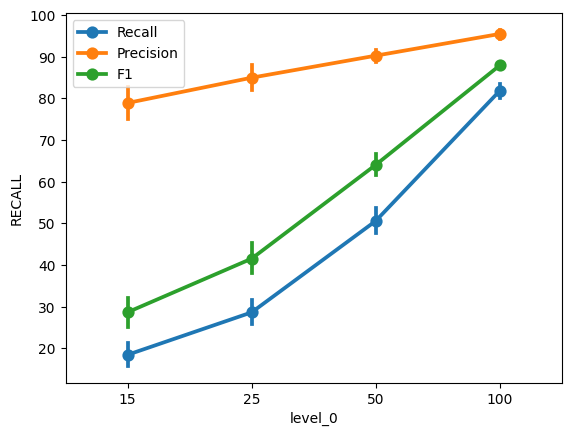

100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.19it/s]


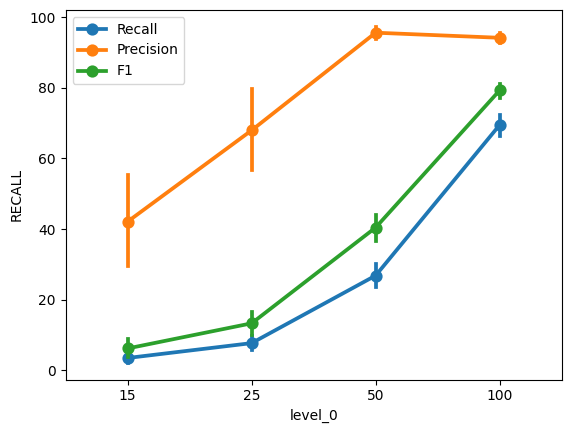

100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.04it/s]


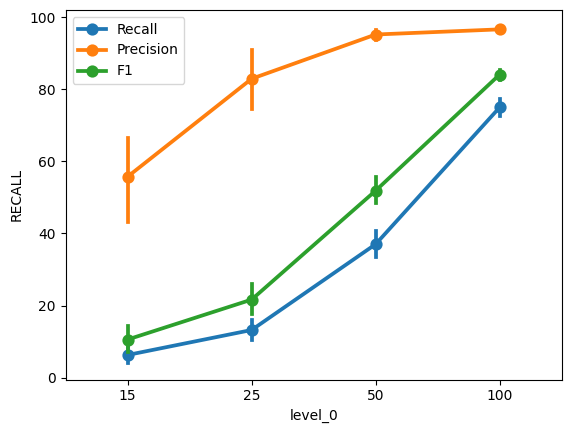

In [16]:
ABRES = {}

for ALPHA, FULLREF in zip(['NA', 'HOLM', 'BH'], [res1, res2, res3]):

    RES = {}

    for SIZE in tqdm([15, 25, 50, 100]):
        for SEED in range(50):
            
            ancomb_res = pd.read_csv(
                f'prodata/test4/ancomb_results_{SIZE}_{SEED}_{ALPHA}.tsv', index_col=0)
            ancomb_res['taxon'] = ancomb_res['taxon'].map({
                v: k
                for k, v in map_columns.items()
            })

            ancomb_res['org'] = ancomb_res['taxon'].apply(
                lambda x: x.split('|')[-1][0])
            ancomb_res = ancomb_res[[
                'taxon', 'org', 'p_GroupIBD', 'passed_ss_GroupIBD', 'q_GroupIBD'
            ]]

            ancomb_res = ancomb_res[(ancomb_res.q_GroupIBD < 0.05)
                                    & (ancomb_res.passed_ss_GroupIBD)]
            FP = len([m for m in ancomb_res.taxon if m not in FULLREF.index])
            TP = len([m for m in ancomb_res.taxon if m in FULLREF.index])

            RECALL = (TP / len(FULLREF.index) *
                      100) if len(ancomb_res.taxon.values) > 0 else 0
            PRECISION = (TP / len(ancomb_res.taxon.values) *
                         100) if len(ancomb_res.taxon.values) > 0 else 0

            F1 = 0
            if PRECISION > 0 and RECALL > 0:
                F1 = 2 * ((PRECISION * RECALL) / (PRECISION + RECALL))

            RES[(SIZE, SEED)] = {
                'FP': FP,
                'TP': TP,
                'RECALL': RECALL,
                'PRECISION': PRECISION,
                'F1': F1,
                'markers': MARKED
            }

    RES = pd.DataFrame(RES).T.reset_index()
    ABRES[ALPHA] = RES
    RES.to_excel(f'prodata/ancomb_ibd_subsets_results_{ALPHA}.xlsx')

    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.pointplot(data=RES, x='level_0', y='RECALL', label='Recall')
    sns.pointplot(data=RES, x='level_0', y='PRECISION', label='Precision')
    sns.pointplot(data=RES, x='level_0', y='F1', label='F1')
    
    plt.show()

<Axes: xlabel='level_0', ylabel='RECALL'>

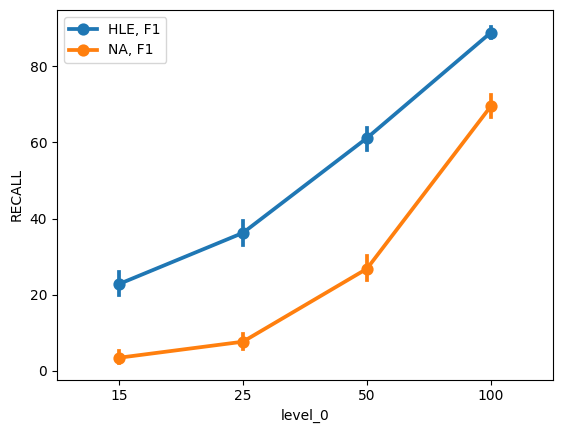

In [27]:
sns.pointplot(data=HLERES[0.05], x='level_0', y='RECALL', label='HLE, F1')
sns.pointplot(data=ABRES['HOLM'], x='level_0', y='RECALL', label='NA, F1')

In [28]:
def f_median(x, precision=2):
    q25 = round(np.nanquantile(x, 0.25), precision)
    q50 = round(np.nanquantile(x, 0.5), precision)
    q75 = round(np.nanquantile(x, 0.75), precision)
    r = f"{q50} (IQR: {q25}; {q75})"
    return r

In [49]:
YY = "PRECISION"


r1 = ABRES['NA'].groupby(['level_0'])[YY].agg(f_median).to_dict()
r2 = ABRES['HOLM'].groupby(['level_0'])[YY].agg(f_median).to_dict()
r3 = ABRES['BH'].groupby(['level_0'])[YY].agg(f_median).to_dict()
r4 = HLERES[0.05].groupby(['level_0'])[YY].agg(f_median).to_dict()
r5 = HLERES[0.01].groupby(['level_0'])[YY].agg(f_median).to_dict()
r6 = HLERES[0.001].groupby(['level_0'])[YY].agg(f_median).to_dict()

df = {'ANCOMB-BC2 (SS Filter), no correction' : r1,
      'ANCOMB-BC2 (SS Filter), Holm–Bonferroni' : r2,
      'ANCOMB-BC2 (SS Filter), Benjamini–Hochberg' : r3,
      
      '95% HLE-CI' : r4,
      '99% HLE-CI' : r5,
      '99.9% HLE-CI' : r6
     }


pd.DataFrame(df).T

,15,25,50,100
"ANCOMB-BC2 (SS Filter), no correction",80.0 (IQR: 71.51; 87.58),86.69 (IQR: 78.05; 93.08),90.97 (IQR: 86.91; 93.92),96.65 (IQR: 93.18; 97.87)
"ANCOMB-BC2 (SS Filter), Holm–Bonferroni",0.0 (IQR: 0.0; 100.0),100.0 (IQR: 0.0; 100.0),100.0 (IQR: 90.0; 100.0),94.74 (IQR: 90.91; 100.0)
"ANCOMB-BC2 (SS Filter), Benjamini–Hochberg",74.17 (IQR: 0.0; 100.0),98.08 (IQR: 81.44; 100.0),96.39 (IQR: 92.86; 100.0),97.26 (IQR: 95.0; 98.62)
95% HLE-CI,83.89 (IQR: 70.94; 89.47),89.33 (IQR: 85.43; 93.21),93.39 (IQR: 91.07; 95.49),95.92 (IQR: 93.93; 96.71)
99% HLE-CI,93.54 (IQR: 80.0; 100.0),95.06 (IQR: 90.23; 100.0),96.75 (IQR: 95.02; 98.35),98.67 (IQR: 96.97; 98.98)
99.9% HLE-CI,100.0 (IQR: 0.0; 100.0),100.0 (IQR: 100.0; 100.0),100.0 (IQR: 95.03; 100.0),96.92 (IQR: 94.33; 100.0)


In [50]:
YY = "RECALL"


r1 = ABRES['NA'].groupby(['level_0'])[YY].agg(f_median).to_dict()
r2 = ABRES['HOLM'].groupby(['level_0'])[YY].agg(f_median).to_dict()
r3 = ABRES['BH'].groupby(['level_0'])[YY].agg(f_median).to_dict()
r4 = HLERES[0.05].groupby(['level_0'])[YY].agg(f_median).to_dict()
r5 = HLERES[0.01].groupby(['level_0'])[YY].agg(f_median).to_dict()
r6 = HLERES[0.001].groupby(['level_0'])[YY].agg(f_median).to_dict()

df = {'ANCOMB-BC2 (SS Filter), no correction' : r1,
      'ANCOMB-BC2 (SS Filter), Holm–Bonferroni' : r2,
      'ANCOMB-BC2 (SS Filter), Benjamini–Hochberg' : r3,
      
      '95% HLE-CI' : r4,
      '99% HLE-CI' : r5,
      '99.9% HLE-CI' : r6
     }


pd.DataFrame(df).T

,15,25,50,100
"ANCOMB-BC2 (SS Filter), no correction",16.51 (IQR: 11.01; 24.54),27.06 (IQR: 19.27; 36.7),51.38 (IQR: 43.12; 58.72),83.49 (IQR: 79.13; 86.01)
"ANCOMB-BC2 (SS Filter), Holm–Bonferroni",0.0 (IQR: 0.0; 6.38),6.38 (IQR: 0.0; 14.89),25.53 (IQR: 15.43; 36.17),70.21 (IQR: 63.83; 76.6)
"ANCOMB-BC2 (SS Filter), Benjamini–Hochberg",2.08 (IQR: 0.0; 10.16),11.46 (IQR: 5.47; 20.57),34.38 (IQR: 26.3; 48.96),76.04 (IQR: 70.05; 81.25)
95% HLE-CI,20.15 (IQR: 13.62; 29.1),36.94 (IQR: 30.04; 41.6),62.69 (IQR: 54.85; 67.72),89.55 (IQR: 86.01; 93.28)
99% HLE-CI,7.44 (IQR: 4.13; 14.05),17.77 (IQR: 12.6; 24.38),42.56 (IQR: 35.74; 48.55),76.86 (IQR: 71.28; 79.34)
99.9% HLE-CI,1.23 (IQR: 0.0; 5.86),6.79 (IQR: 3.7; 9.88),27.78 (IQR: 21.3; 36.42),74.69 (IQR: 67.9; 81.17)


In [51]:
YY = "F1"


r1 = ABRES['NA'].groupby(['level_0'])[YY].agg(f_median).to_dict()
r2 = ABRES['HOLM'].groupby(['level_0'])[YY].agg(f_median).to_dict()
r3 = ABRES['BH'].groupby(['level_0'])[YY].agg(f_median).to_dict()
r4 = HLERES[0.05].groupby(['level_0'])[YY].agg(f_median).to_dict()
r5 = HLERES[0.01].groupby(['level_0'])[YY].agg(f_median).to_dict()
r6 = HLERES[0.001].groupby(['level_0'])[YY].agg(f_median).to_dict()

df = {'ANCOMB-BC2 (SS Filter), no correction' : r1,
      'ANCOMB-BC2 (SS Filter), Holm–Bonferroni' : r2,
      'ANCOMB-BC2 (SS Filter), Benjamini–Hochberg' : r3,
      
      '95% HLE-CI' : r4,
      '99% HLE-CI' : r5,
      '99.9% HLE-CI' : r6
     }


pd.DataFrame(df).T

,15,25,50,100
"ANCOMB-BC2 (SS Filter), no correction",27.27 (IQR: 18.9; 37.97),41.7 (IQR: 31.24; 52.72),64.74 (IQR: 58.78; 71.32),87.88 (IQR: 86.29; 90.01)
"ANCOMB-BC2 (SS Filter), Holm–Bonferroni",0.0 (IQR: 0.0; 12.0),12.0 (IQR: 0.0; 25.45),40.68 (IQR: 26.72; 52.58),81.01 (IQR: 75.3; 84.97)
"ANCOMB-BC2 (SS Filter), Benjamini–Hochberg",4.08 (IQR: 0.0; 18.05),20.47 (IQR: 10.37; 32.91),50.97 (IQR: 40.89; 64.51),85.79 (IQR: 81.47; 87.64)
95% HLE-CI,32.41 (IQR: 23.4; 43.88),52.67 (IQR: 43.7; 56.82),74.94 (IQR: 68.11; 77.96),92.58 (IQR: 89.85; 94.11)
99% HLE-CI,13.53 (IQR: 7.94; 24.16),29.65 (IQR: 22.26; 38.62),59.12 (IQR: 52.5; 64.75),86.3 (IQR: 82.83; 87.94)
99.9% HLE-CI,2.44 (IQR: 0.0; 11.07),12.71 (IQR: 7.14; 17.98),43.47 (IQR: 34.85; 52.59),85.11 (IQR: 80.07; 87.42)


In [64]:
92.58 - 85.79

6.789999999999992